In [2]:
import pandas as pd
from egoviz.models.processing import load_pickle

SEED = 42

In [3]:
data = load_pickle("../data/home_data_detic_preds.pkl")

In [4]:
len(data)

29393

### Create a DataFrame from the dictionary

In [5]:
# create data df
df = pd.DataFrame(columns=['video', 'frame', 'classes', 'adl'])

for id, dets in data.items():
    adl = id.split('_', 1)[0]
    video = id.split('_')[1]
    frame = id.split('_')[2]
    classes = dets['remapped_metadata']

    row = {'video': video, 'frame': frame, 'classes': classes, 'adl': adl}

    df.loc[len(df)] = row

# one hot encode the classes but add counts for each class

# create a list of all classes
all_classes = []
for classes in df['classes']:
    all_classes.extend(classes)
    
# remove duplicates
all_classes = list(set(all_classes))

# create a column for each class
for c in all_classes:
    df[c] = 0

# loop through rows and set the value of the class column to the 
# number of times it appears in the classes column
for i, row in df.iterrows():
    for c in row['classes']:
        df.at[i, c] += 1

df.head()

,video,frame,classes,adl,wheelchair_walker,other,footwear,tv_computer,hat,animal,...,furniture,electronics,sink,drinkware,clothing,office_stationary,clothing_accessory,tableware,bag,furnishing
0,SCI06-10--13,frame0,"[phone_tablet, clothing_accessory, office_stat...",communication-management,0,1,2,0,0,0,...,1,0,0,0,0,3,1,0,0,0
1,SCI06-10--1,frame0,[],communication-management,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,SCI06-10--15,frame0,"[phone_tablet, clothing_accessory, office_stat...",communication-management,0,1,2,0,0,0,...,0,0,0,0,0,2,1,0,0,0
3,SCI06-10--16,frame0,"[phone_tablet, office_stationary, other, footw...",communication-management,0,1,4,0,0,0,...,0,0,0,0,0,2,2,0,0,1
4,SCI06-10--2,frame0,"[clothing_accessory, other, office_stationary,...",communication-management,0,2,2,0,0,0,...,1,0,0,0,0,2,1,0,0,2


In [6]:
# group by video and sum the counts for each class, drop the frame and classes columns, adl should be the same for each row in the group

df_grouped = df.groupby(['video', 'adl']).sum().reset_index()
df_grouped = df_grouped.drop(columns=['frame', 'classes'])

In [7]:
df_grouped

,video,adl,wheelchair_walker,other,footwear,tv_computer,hat,animal,food,bathroom_fixture,...,furniture,electronics,sink,drinkware,clothing,office_stationary,clothing_accessory,tableware,bag,furnishing
0,SCI02-1--1,functional-mobility,0,7,3,0,0,2,51,4,...,10,3,6,19,3,13,0,6,4,8
1,SCI02-1--10,meal-preparation-cleanup,0,6,1,0,0,141,49,6,...,2,0,15,18,1,2,2,18,2,3
2,SCI02-1--11,meal-preparation-cleanup,0,2,0,0,0,199,90,13,...,0,0,18,7,0,0,1,25,0,1
3,SCI02-1--12,meal-preparation-cleanup,0,8,0,0,0,114,83,7,...,4,0,14,28,0,3,0,21,3,2
4,SCI02-1--2,meal-preparation-cleanup,0,6,1,0,0,3,95,11,...,2,3,13,47,0,2,10,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,SCI21-9--4,meal-preparation-cleanup,0,27,3,0,0,1,238,8,...,53,4,13,48,0,38,0,10,11,16
2257,SCI21-9--5,meal-preparation-cleanup,0,15,0,0,0,2,248,6,...,74,2,15,58,0,42,0,13,16,18
2258,SCI21-9--6,meal-preparation-cleanup,0,34,2,0,0,6,221,1,...,70,2,19,56,2,41,0,20,22,29
2259,SCI21-9--7,meal-preparation-cleanup,0,15,2,0,0,1,95,5,...,30,1,15,38,1,22,2,14,8,9


### Train a simple model to predict ADL

In [8]:
from sklearn.model_selection import train_test_split

X = df_grouped.drop(columns=['adl', 'video'])
y = df_grouped['adl']

# split into train and test sets stratified by y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)

In [9]:
# train a model
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=SEED)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
# evaluate model
from egoviz.models.evaluation import evaluate_model, evaluate_k_fold

report, cm, preds_df = evaluate_model(clf, X_test, y_test)
print(report); print(cm)

                            precision    recall  f1-score   support

  communication-management       0.90      0.99      0.94       128
       functional-mobility       0.98      0.76      0.85        62
grooming-health-management       0.94      0.65      0.77        52
           home-management       0.83      0.91      0.87       122
  leisure-other-activities       0.96      0.86      0.91        50
  meal-preparation-cleanup       0.93      0.98      0.95       188
              self-feeding       0.95      0.94      0.94        77

                  accuracy                           0.91       679
                 macro avg       0.93      0.87      0.89       679
              weighted avg       0.92      0.91      0.91       679

[[127   0   0   0   0   1   0]
 [  4  47   0   8   1   2   0]
 [  4   0  34   9   0   2   3]
 [  2   1   0 111   1   7   0]
 [  3   0   1   2  43   0   1]
 [  0   0   0   3   0 185   0]
 [  1   0   1   0   0   3  72]]


In [11]:
clf2 = RandomForestClassifier(n_estimators=100, random_state=SEED)
evaluate_k_fold(clf2, X, y, k=5, seed=SEED)

f1_macro: 0.8919409912155555 +/- 0.013842065915101462


,fit_time,score_time,test_f1_macro,train_f1_macro,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,model,mean_f1_macro,std_f1_macro
0,0.297657,0.010995,0.899984,1.0,0.918819,1.0,0.891197,1.0,RandomForestClassifier,0.89,0.02
1,0.293355,0.010999,0.878536,1.0,0.910961,1.0,0.864598,1.0,RandomForestClassifier,0.89,0.02
2,0.300171,0.011000,0.887886,1.0,0.913317,1.0,0.869827,1.0,RandomForestClassifier,0.89,0.02
3,0.293527,0.010507,0.878583,1.0,0.898688,1.0,0.866393,1.0,RandomForestClassifier,0.89,0.02
4,0.294531,0.010999,0.914717,1.0,0.935870,1.0,0.898514,1.0,RandomForestClassifier,0.89,0.02


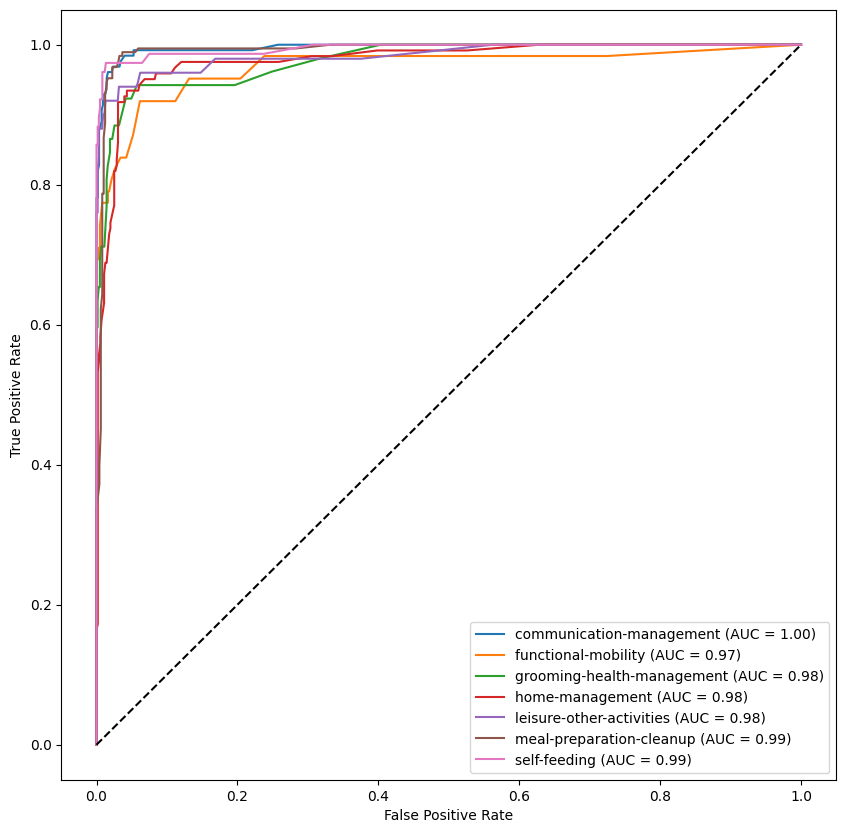

In [12]:
# plot AUC for each class
from sklearn.metrics import roc_curve, auc

# get probabilities for each class
probs = clf.predict_proba(X_test)

# get fpr, tpr and auc for each class
fpr = {}
tpr = {}
aucs = {}

for i, c in enumerate(clf.classes_):
    fpr[c], tpr[c], _ = roc_curve(y_test, probs[:, i], pos_label=c)
    aucs[c] = auc(fpr[c], tpr[c])

# plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for c in clf.classes_:
    plt.plot(fpr[c], tpr[c], label=f'{c} (AUC = {aucs[c]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()